In [1]:
import bs4 as bs
import requests
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
import matplotlib
matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'font.size': 15,
    'figure.figsize': (16,9), 
    'lines.linewidth': 0.8
    })
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import coint
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import random
from scipy.stats import linregress
import warnings 
warnings.filterwarnings("ignore") 

In [66]:
resp = requests.get('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[1].text
    tickers.append(ticker)
tickers = [s.replace('\n', '') for s in tickers]

In [67]:
start = datetime.datetime(2009, 1, 1)
end = datetime.datetime(2024, 1, 1)
data = yf.download(tickers, start=start, end=end)   

[*********************100%%**********************]  30 of 30 completed


In [68]:
prices = data['Adj Close']
prices


Ticker,AAPL,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,MMM,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-02,2.740172,42.107327,2.718000,15.098139,33.941097,30.837603,8.493905,11.501412,41.520561,20.530584,...,27.784302,17.348499,15.011643,10.920245,39.741730,31.016994,22.278543,11.963102,14.871540,13.571186
2009-01-05,2.855818,42.578426,2.703000,15.582409,34.631180,30.291981,8.326623,11.603137,41.596527,20.170097,...,27.460403,17.085484,15.151937,10.998451,39.456959,30.557219,21.915182,12.048168,13.944218,13.414537
2009-01-06,2.808715,41.643345,2.868000,16.457207,34.736176,30.107910,8.638715,12.064273,41.970924,20.865322,...,27.784302,16.772085,15.329156,10.776178,39.343060,29.623964,21.398392,12.896598,13.720973,13.295869
2009-01-07,2.748023,41.543411,2.810000,15.763944,33.573547,28.707693,7.989563,11.745543,40.131485,19.895443,...,27.258551,16.503466,14.406159,10.385143,38.653267,28.450537,21.236889,12.616776,13.895201,13.181943
2009-01-08,2.799053,42.300045,2.858000,15.787580,33.596058,28.937769,8.216766,11.894736,40.283421,19.655117,...,27.497957,16.430716,14.856584,10.576544,38.229282,28.978918,21.567959,12.482460,14.108643,12.194601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,193.091385,279.967377,153.419998,184.401108,260.440002,287.971252,265.992523,49.300465,147.925827,91.019997,...,86.566193,107.021141,373.215393,107.236305,143.442032,184.045853,518.266907,257.472504,36.280762,51.859924
2023-12-26,192.542816,279.711182,153.410004,184.788651,262.790009,293.197906,265.872711,49.487465,149.257706,90.949997,...,88.015350,106.951584,373.295135,107.216446,144.093674,185.323669,517.988037,258.199799,36.271076,51.780468
2023-12-27,192.642548,282.302399,153.339996,185.881699,262.100006,295.667419,266.372040,49.644943,148.768051,90.379997,...,88.528252,107.299385,372.707275,106.333069,144.212158,186.839218,520.737183,257.970642,36.106567,52.267120


In [69]:
prices.isnull().sum()

Ticker
AAPL       0
AMGN       0
AMZN       0
AXP        0
BA         0
CAT        0
CRM        0
CSCO       0
CVX        0
DIS        0
DOW     2569
GS         0
HD         0
HON        0
IBM        0
INTC       0
JNJ        0
JPM        0
KO         0
MCD        0
MMM        0
MRK        0
MSFT       0
NKE        0
PG         0
TRV        0
UNH        0
V          0
VZ         0
WMT        0
dtype: int64

In [70]:
prices.drop(columns=['DOW'], inplace=True)
tickers.remove('DOW')

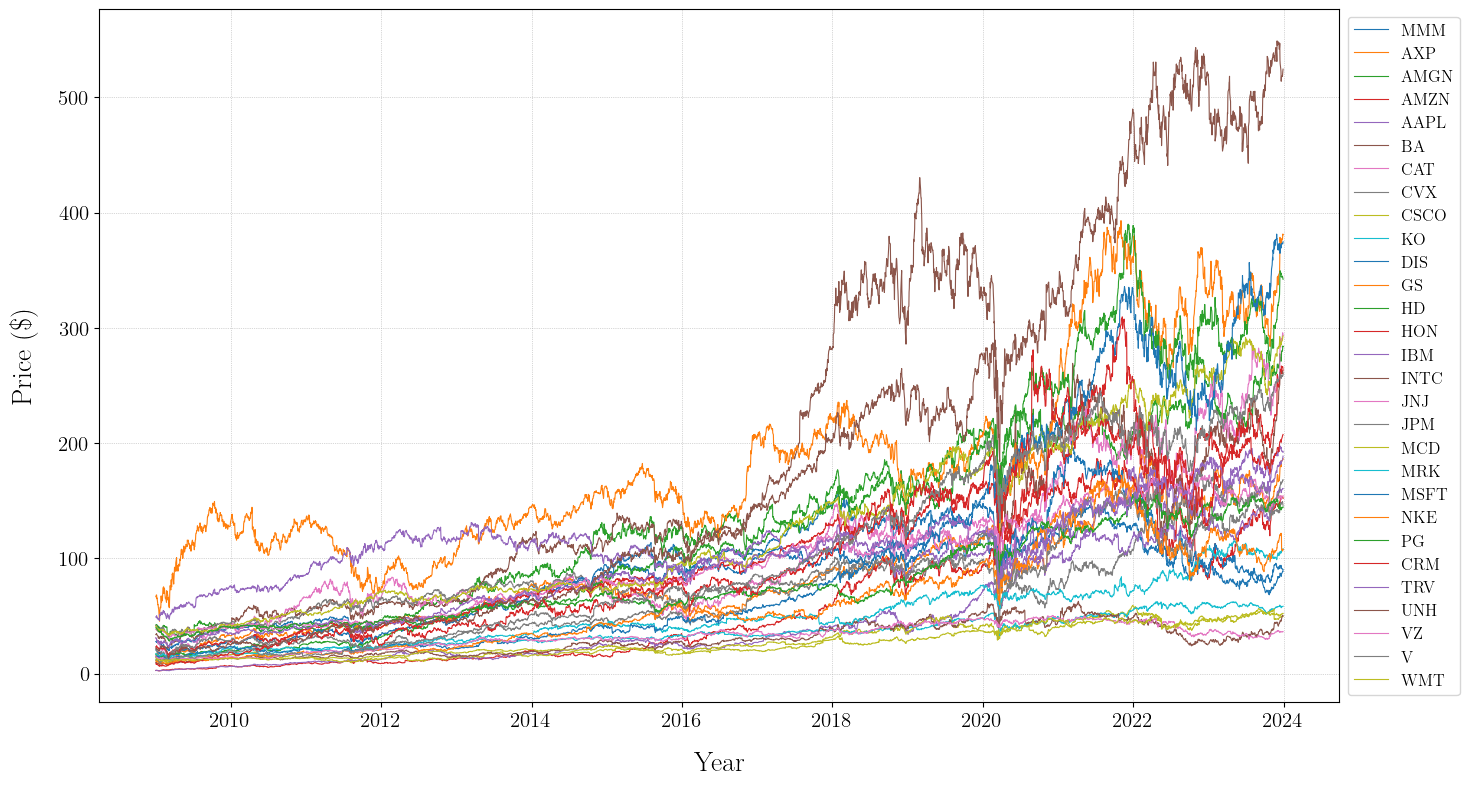

In [71]:
for ticker in tickers:
    plt.plot(prices[ticker], label=ticker)

plt.xlabel('Year', fontsize=20, labelpad=15)
plt.ylabel('Price (\$)', fontsize=20, labelpad=15)
plt.grid(linestyle=':', linewidth=0.5)
plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5));

[*********************100%%**********************]  1 of 1 completed


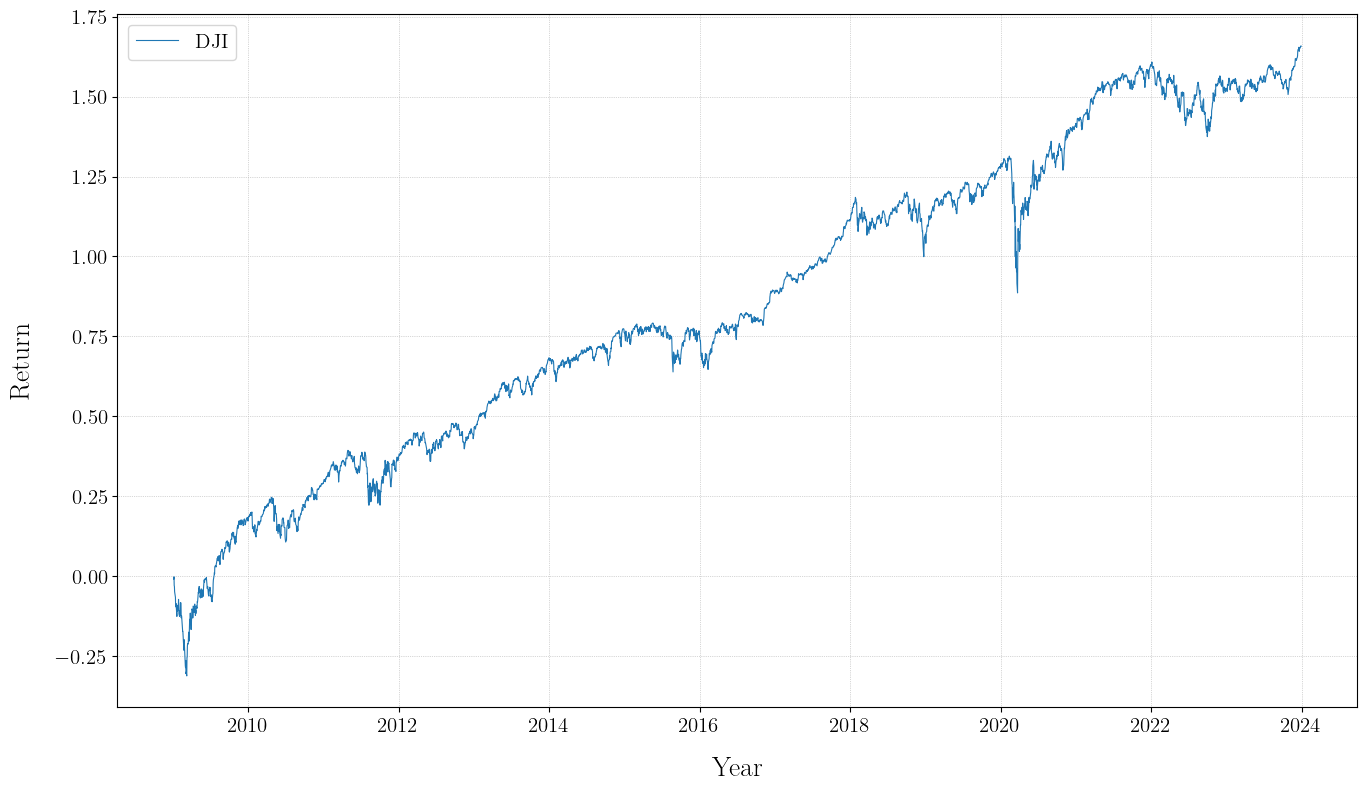

In [73]:
index = yf.download('^DJI', start=start, end=end)   
prices_index = index['Adj Close']

plt.plot(prices_index.pct_change().cumsum(), label = "DJIA")
plt.xlabel('Year', fontsize = 20, labelpad = 15)
plt.ylabel('Return', fontsize = 20, labelpad = 15)
plt.grid(linestyle = ':', linewidth = 0.5)
plt.legend();

In [76]:
stock_pairs = list(itertools.combinations(tickers, 2))

In [77]:
def dickey_fuller(x):
    stat, p, lags, obs, crit, t = adfuller(x)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably not Stationary')
    else:
        print('Probably Stationary')

In [78]:
cointegrated_pairs = []

with tqdm(total=len(stock_pairs)) as pbar:  
    for row in stock_pairs:
        try:
            ticker_A, ticker_B = row
            asset_A = prices[ticker_A]
            asset_B = prices[ticker_B]
            if coint(asset_A, asset_B)[1] < 0.05:
                cointegrated_pairs.append(row)
        except:
            pass
        # Update tqdm progress bar
        pbar.update(1)

100%|██████████| 406/406 [01:24<00:00,  4.79it/s]


In [79]:
cointegrated_pairs

[('AXP', 'AMGN'),
 ('AXP', 'CAT'),
 ('AXP', 'KO'),
 ('AXP', 'HD'),
 ('AXP', 'MCD'),
 ('AXP', 'PG'),
 ('AXP', 'UNH'),
 ('AXP', 'WMT'),
 ('AMGN', 'KO'),
 ('AMGN', 'HD'),
 ('AMGN', 'HON'),
 ('AMGN', 'JNJ'),
 ('AMGN', 'TRV'),
 ('AMGN', 'V'),
 ('AMGN', 'WMT'),
 ('AMZN', 'NKE'),
 ('AMZN', 'CRM'),
 ('AAPL', 'CAT'),
 ('AAPL', 'MSFT'),
 ('CAT', 'MSFT'),
 ('CAT', 'UNH'),
 ('CSCO', 'HD'),
 ('CSCO', 'HON'),
 ('CSCO', 'JPM'),
 ('CSCO', 'CRM'),
 ('KO', 'HD'),
 ('KO', 'MRK'),
 ('KO', 'PG'),
 ('KO', 'TRV'),
 ('KO', 'UNH'),
 ('KO', 'WMT'),
 ('DIS', 'VZ'),
 ('GS', 'HD'),
 ('GS', 'UNH'),
 ('HD', 'HON'),
 ('HD', 'JPM'),
 ('HD', 'MCD'),
 ('HD', 'PG'),
 ('HD', 'CRM'),
 ('HD', 'UNH'),
 ('HD', 'V'),
 ('HD', 'WMT'),
 ('HON', 'JNJ'),
 ('HON', 'CRM'),
 ('INTC', 'VZ'),
 ('JPM', 'MCD'),
 ('JPM', 'CRM'),
 ('JPM', 'V'),
 ('JPM', 'WMT'),
 ('MCD', 'UNH'),
 ('MCD', 'WMT'),
 ('NKE', 'CRM'),
 ('PG', 'CRM'),
 ('PG', 'WMT'),
 ('CRM', 'V'),
 ('CRM', 'WMT'),
 ('V', 'WMT')]

## Pairs Analysis

In [80]:
ticker_A, ticker_B = ('AAPL', 'MSFT')
start = datetime.datetime(2009, 1, 1)
end = datetime.datetime(2024, 1, 1)
data = yf.download((ticker_A, ticker_B), start=start, end=end)
prices = data['Adj Close']
asset_A = prices[ticker_A]
asset_B = prices[ticker_B]


[*********************100%%**********************]  2 of 2 completed


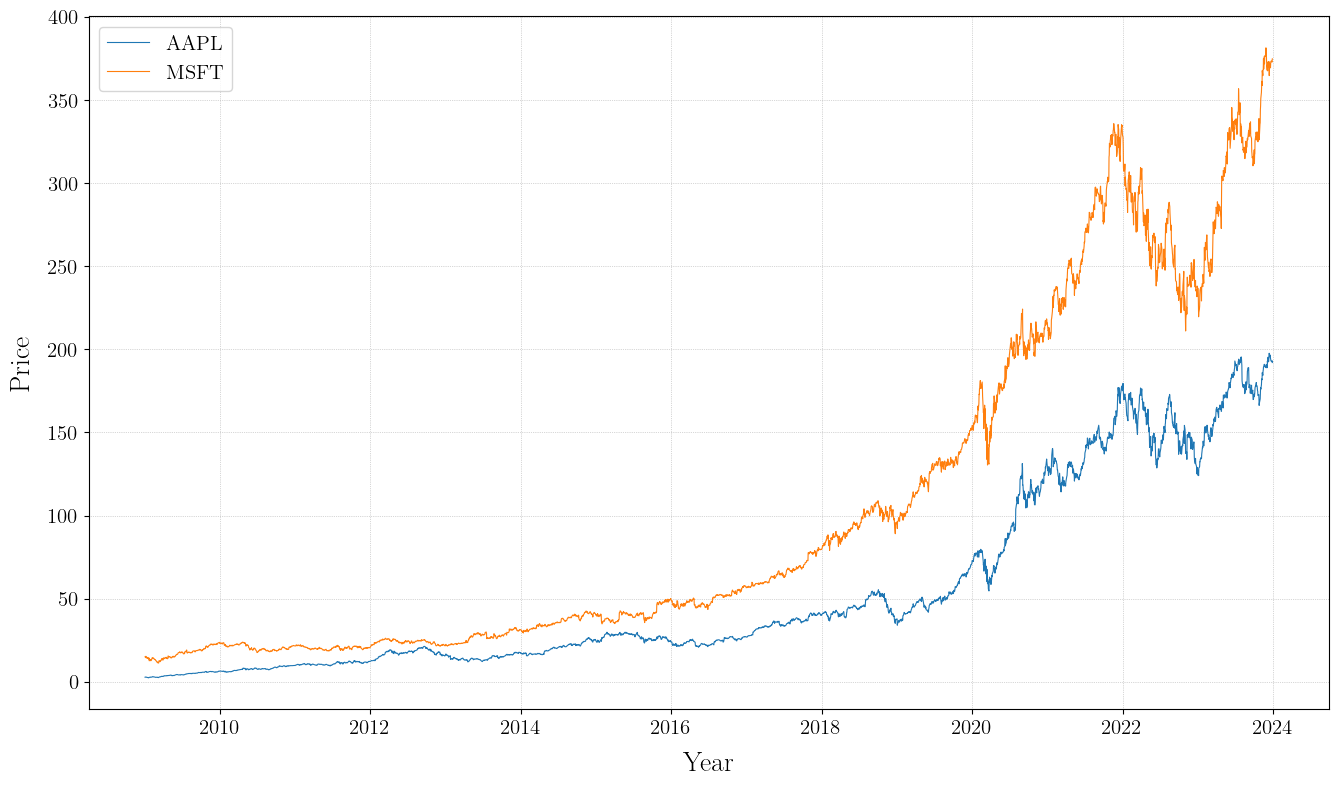

In [81]:
plt.plot(asset_A, label = ticker_A)  
plt.plot(asset_B, label = ticker_B)  
plt.xlabel('Year', fontsize = 20, labelpad = 10)
plt.ylabel('Price', fontsize = 20, labelpad = 10)
plt.grid(linestyle = ':', linewidth = 0.5)
plt.legend();

In [82]:
def spread_calc(asset_A, asset_B):
    reg = linregress(asset_A, asset_B)
    beta = reg.slope
    spread = asset_B - beta * asset_A
    
    # Normalize spread
    normalized_spread = (spread - spread.mean()) / spread.std()
    spread_df = pd.DataFrame(normalized_spread, columns=['Spread'])
    return spread_df

In [83]:
spread_df = spread_calc(asset_A, asset_B)

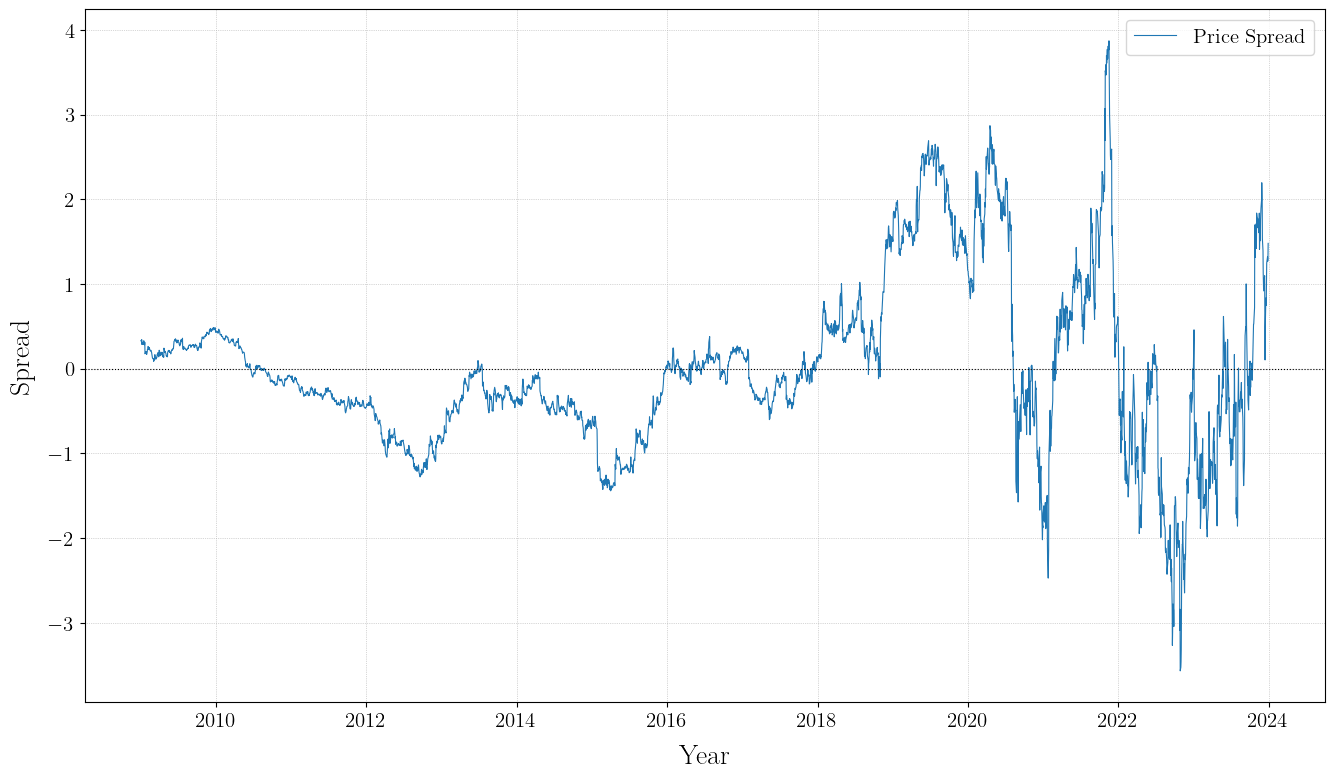

In [84]:
plt.plot(spread_df)
plt.xlabel('Year', fontsize = 20, labelpad = 10)
plt.ylabel('Spread', fontsize = 20, labelpad = 10)
plt.axhline(0, color='black', linestyle = ':')
plt.grid(linestyle = ':', linewidth = 0.5)
plt.legend(['Price Spread']);

In [21]:
percentage_change = (train_spread.pct_change() * 100).dropna()

In [22]:
positive_decile = np.percentile(percentage_change['Spread'], 90)
positive_quintile = np.percentile(percentage_change['Spread'], 80)

negative_decile = np.percentile(percentage_change['Spread'], 10)
negative_quintile = np.percentile(percentage_change['Spread'], 20)

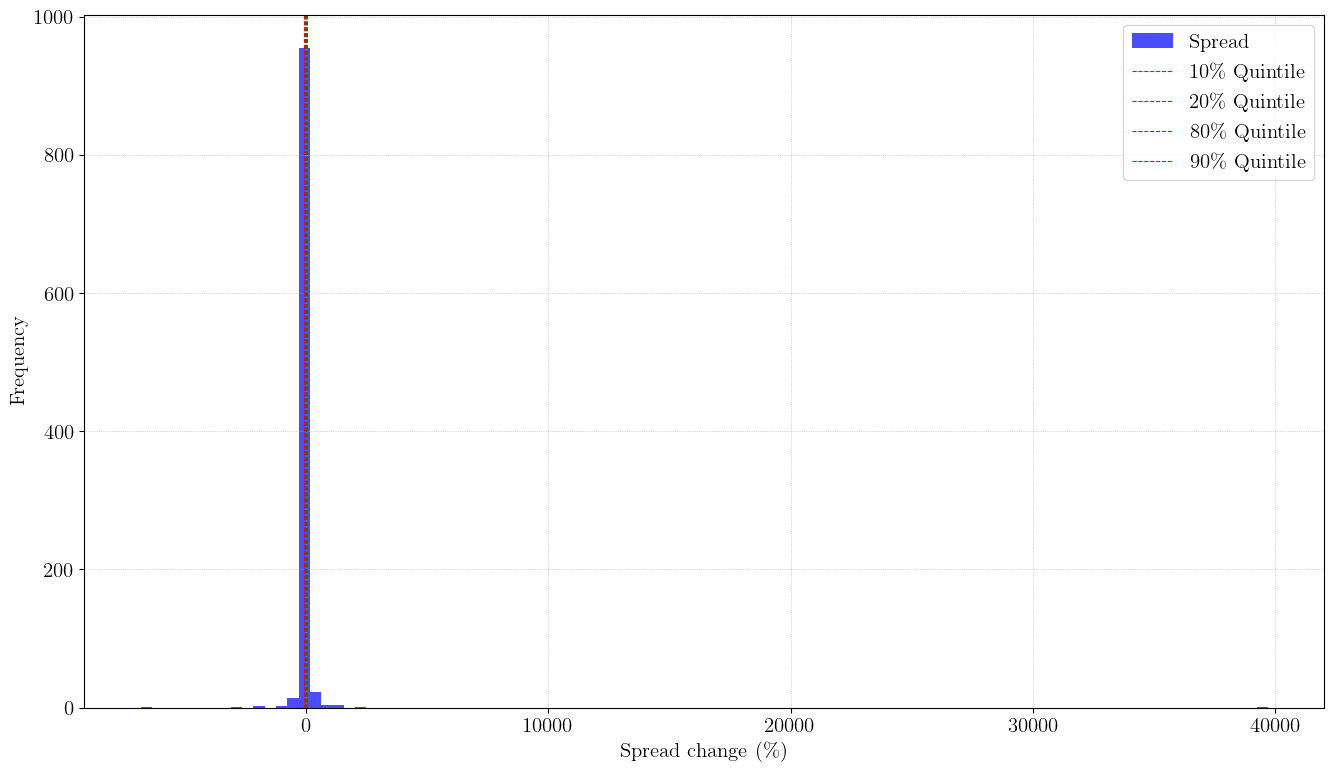

In [23]:
percentage_change['Spread'].plot.hist(color='blue', alpha=0.7, bins=100)
plt.xlabel('Spread change (\%)')
plt.ylabel('Frequency')
plt.grid(linestyle = ':', linewidth = 0.5)
plt.axvline(negative_decile, color='red', linestyle='--', label='10\% Quintile')
plt.axvline(negative_quintile, color='green', linestyle='--', label='20\% Quintile')
plt.axvline(positive_quintile, color='green', linestyle='--', label='80\% Quintile')
plt.axvline(positive_decile, color='red', linestyle='--', label='90\% Quintile')
plt.legend();

In [24]:
# removing outliers considering only changes in the interval [-50, 50]
percentage_change = percentage_change[(percentage_change['Spread'] >= -50) & (percentage_change['Spread'] <= 50)]

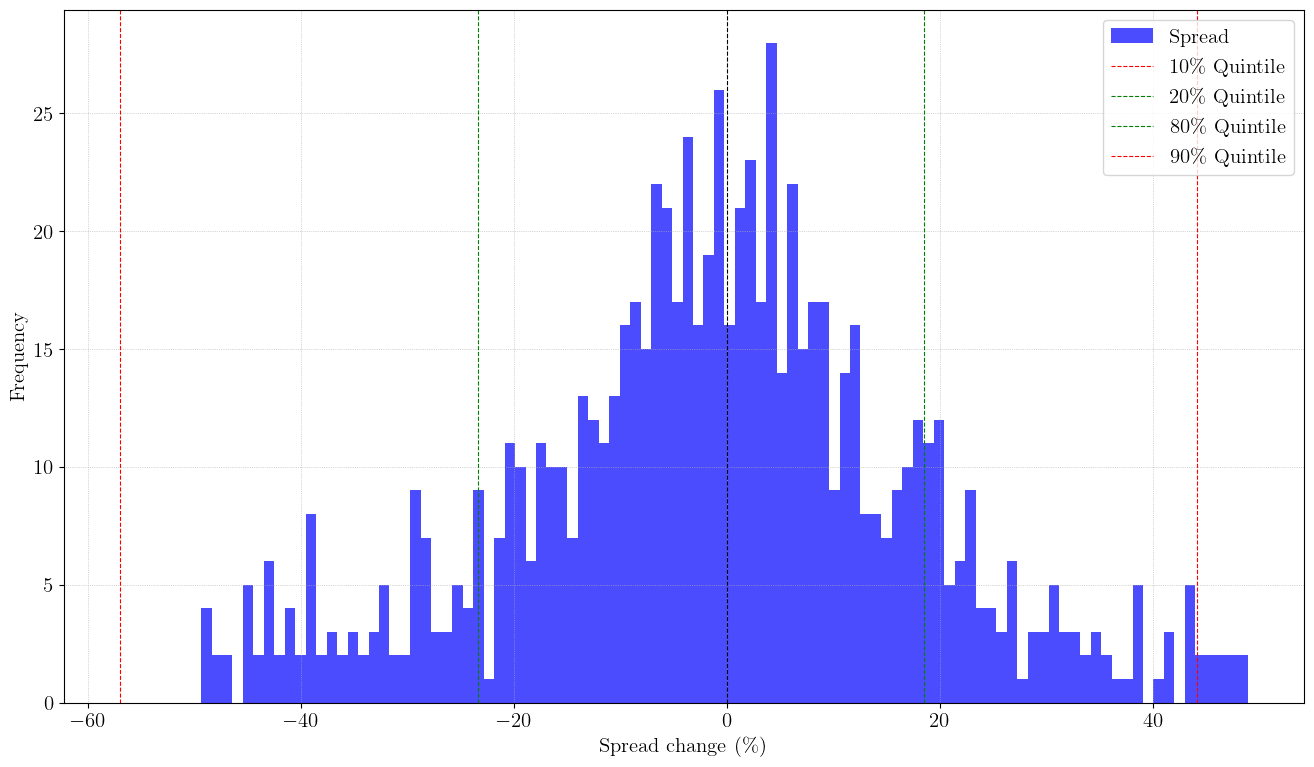

In [25]:
percentage_change['Spread'].plot.hist(color='blue', alpha=0.7, bins=100)
plt.xlabel('Spread change (\%)')
plt.ylabel('Frequency')
plt.grid(linestyle = ':', linewidth = 0.5)
plt.axvline(0, color='black', linestyle='--')
plt.axvline(negative_decile, color='red', linestyle='--', label='10\% Quintile')
plt.axvline(negative_quintile, color='green', linestyle='--', label='20\% Quintile')
plt.axvline(positive_quintile, color='green', linestyle='--', label='80\% Quintile')
plt.axvline(positive_decile, color='red', linestyle='--', label='90\% Quintile')
plt.legend();

## Time Series Forecasting

In [26]:
train_data = train_spread
test_data = test_spread

### ARMA Model

In [27]:
from tqdm import tqdm

history = [x for x in train_data['Spread']]
output_arma = []

# Initialize tqdm with the length of test_data
with tqdm(total=len(test_data)) as pbar:
    # Walk-forward validation
    for t in range(len(test_data)):
        model = ARIMA(history, order=(1, 0, 1))
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        obs = test_data.iloc[t]['Spread'] 
        date = test_data.index[t]

        output_arma.append({
                'Date': date,
                'Observed': obs,
                'Forecasted': yhat
            })

        history.append(obs)
        
        # Update tqdm progress bar
        pbar.update(1)


100%|██████████| 250/250 [00:25<00:00,  9.92it/s]


In [28]:
output_arma_df = pd.DataFrame(output_arma)
output_arma_df.set_index('Date', inplace=True)
output_arma_df

,Observed,Forecasted
Date,,
2023-01-03,0.412772,3.271279
2023-01-04,0.722226,0.215179
2023-01-05,1.108390,0.720644
2023-01-06,1.552676,1.098283
2023-01-09,0.274858,1.537552
...,...,...
2023-12-22,1.419970,0.949250
2023-12-26,1.443713,1.376950
2023-12-27,1.556663,1.397861


Test RMSE: 0.4220


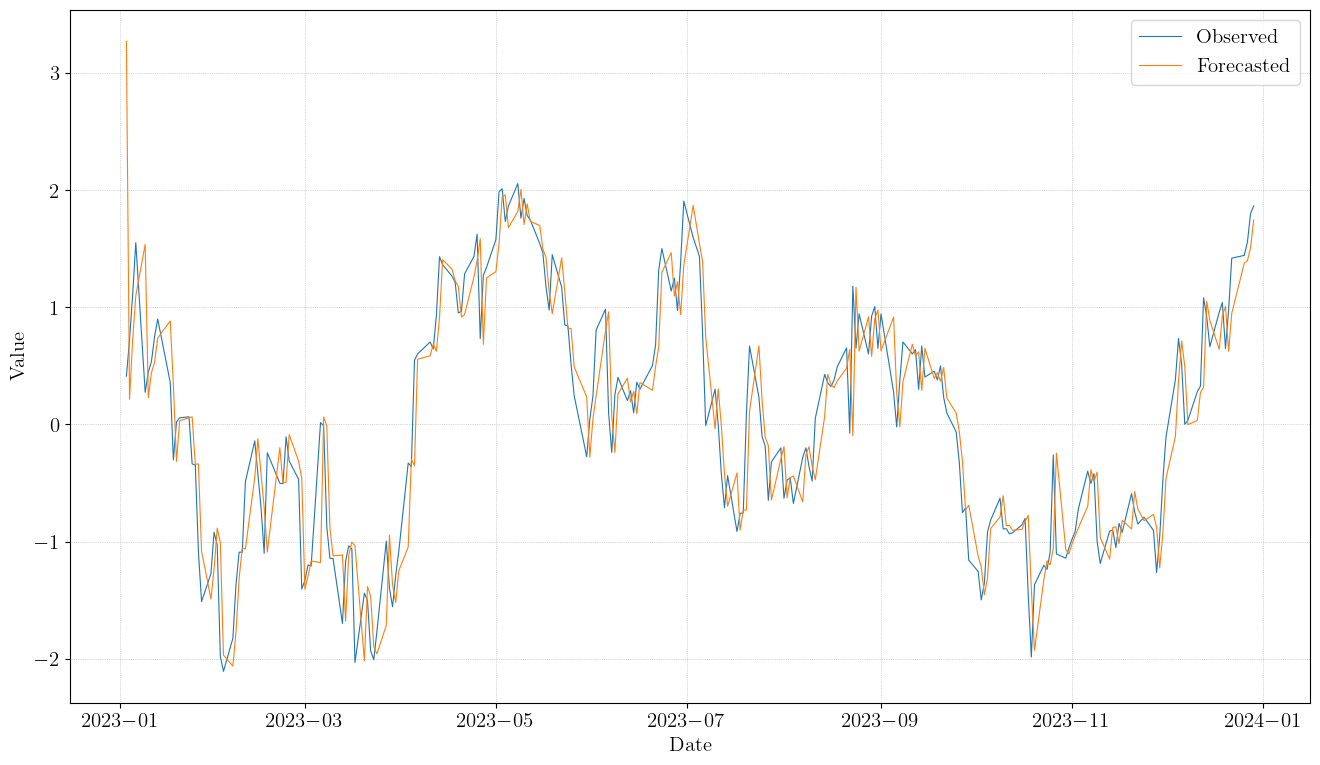

In [29]:
# Plot observed and predicted values
plt.plot(output_arma_df['Observed'], label='Observed')
plt.plot(output_arma_df['Forecasted'], label='Forecasted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(linestyle = ':', linewidth = 0.5)
plt.legend();
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(output_arma_df['Observed'], output_arma_df['Forecasted']))
print('Test RMSE: %.4f' % rmse)


### LSTM Neural Network

In [30]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [31]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [32]:
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.fit_transform(test_data)

In [33]:
# Define a function to create input/output sequences
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [34]:
look_back = 1
X_train, y_train = create_dataset(train_data_scaled, look_back) 
X_test, y_test = create_dataset(test_data_scaled, look_back)

In [35]:
# Reverse scaling for X_test
X_test_original = scaler.inverse_transform(X_test.reshape(-1, 1))

# Reverse scaling for y_test
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

In [36]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [37]:
model_lstm = Sequential()
model_lstm.add(LSTM(4, input_shape=(1, look_back)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
1006/1006 - 1s - 844us/step - loss: 0.0322
Epoch 2/100
1006/1006 - 0s - 358us/step - loss: 0.0048
Epoch 3/100
1006/1006 - 0s - 360us/step - loss: 0.0014
Epoch 4/100
1006/1006 - 0s - 359us/step - loss: 0.0012
Epoch 5/100
1006/1006 - 0s - 355us/step - loss: 0.0012
Epoch 6/100
1006/1006 - 0s - 355us/step - loss: 0.0012
Epoch 7/100
1006/1006 - 0s - 358us/step - loss: 0.0012
Epoch 8/100
1006/1006 - 0s - 360us/step - loss: 0.0012
Epoch 9/100
1006/1006 - 0s - 359us/step - loss: 0.0011
Epoch 10/100
1006/1006 - 0s - 357us/step - loss: 0.0011
Epoch 11/100
1006/1006 - 0s - 359us/step - loss: 0.0011
Epoch 12/100
1006/1006 - 0s - 361us/step - loss: 0.0011
Epoch 13/100
1006/1006 - 0s - 363us/step - loss: 0.0011
Epoch 14/100
1006/1006 - 0s - 357us/step - loss: 0.0011
Epoch 15/100
1006/1006 - 0s - 355us/step - loss: 0.0011
Epoch 16/100
1006/1006 - 0s - 360us/step - loss: 0.0011
Epoch 17/100
1006/1006 - 0s - 357us/step - loss: 0.0011
Epoch 18/100
1006/1006 - 0s - 358us/step - loss: 0.0011
E

In [38]:
predicted_values_lstm = scaler.inverse_transform(model_lstm.predict(X_test))
observed_values_lstm = scaler.inverse_transform(X_test.reshape(-1, X_test.shape[-1]))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [39]:
output_lstm = []

for t in range(len(observed_values_lstm)):
    output_lstm.append({
        'Date': test_data.index[t],
        'Observed': observed_values_lstm[t, 0],
        'Forecasted': predicted_values_lstm[t, 0]
    })

output_lstm_df = pd.DataFrame(output_lstm)
output_lstm_df.set_index('Date', inplace=True)
output_lstm_df

,Observed,Forecasted
Date,,
2023-01-03,0.412772,0.379509
2023-01-04,0.722226,0.680977
2023-01-05,1.108390,1.050579
2023-01-06,1.552676,1.464222
2023-01-09,0.274858,0.244008
...,...,...
2023-12-20,0.647517,0.608572
2023-12-21,0.979670,0.928315
2023-12-22,1.419970,1.342118


Test RMSE: 0.0466


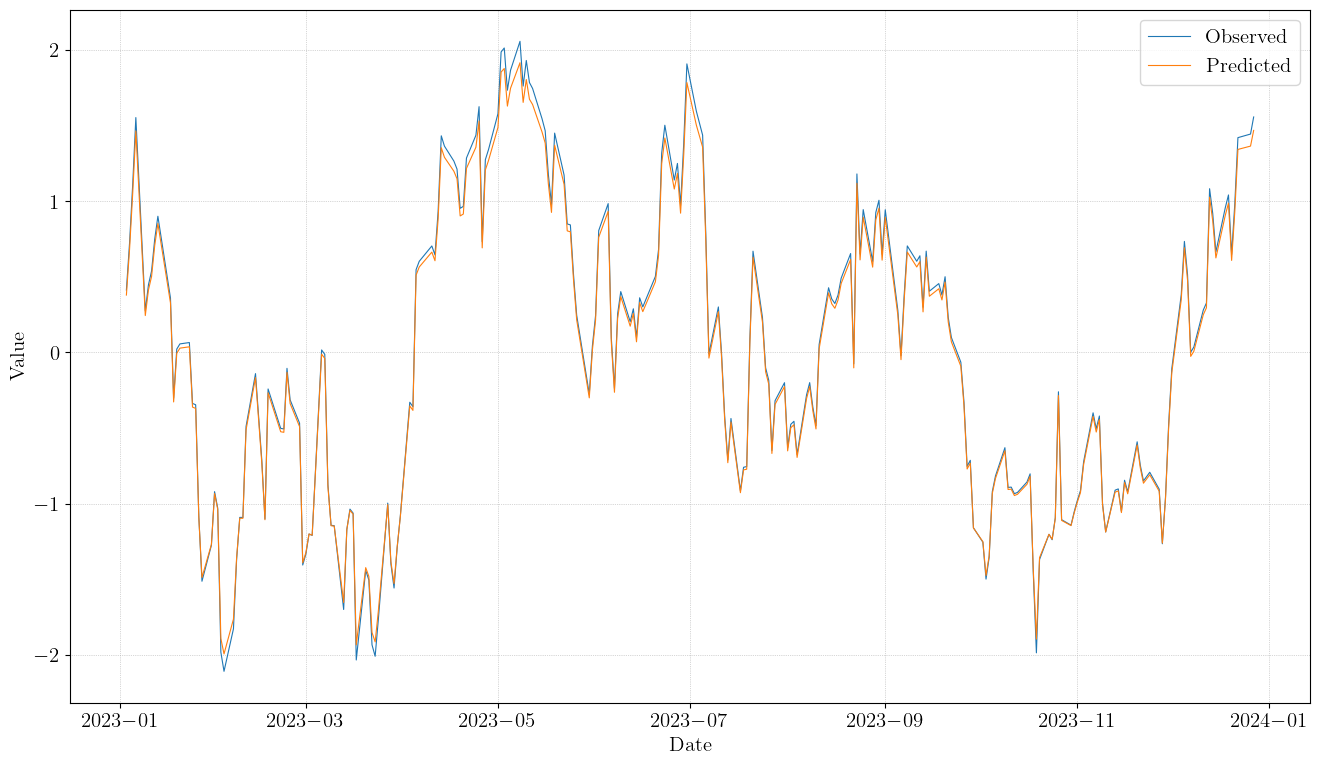

In [40]:
# Plot observed and predicted values
plt.plot(output_lstm_df['Observed'], label='Observed')
plt.plot(output_lstm_df['Forecasted'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(linestyle = ':', linewidth = 0.5)
plt.legend();
rmse = np.sqrt(mean_squared_error(output_lstm_df['Observed'], output_lstm_df['Forecasted']))
print('Test RMSE: %.4f' % rmse)

## Trading Model

The stretegy presented continuously monitors the percentage change between the spread at the current time, and the predicted spread in the next time-step. When the absolute value of the predicted change is larger than a predefined threshold, a position is entered, on the expectation that the spread suffers an abrupt movement from which the investor can benefit from.
To do so, we define $S_t$ and $S^{*}_{t}$ as the true and predicted value for the spread at time t, respectively. The predicted change is then given by:
$$
\Delta_{t+1}=\frac{S_{t+1}^*-S_t}{S_t} \times 100
$$
Having calculated the spread predicted change, the position settlement conditions work as:
$$
\text { Market conditions : } 
\begin{cases}
\text { if } \Delta_{t+1} \geq \alpha_L, & \text { open long position while }\alpha_L>\Delta_{t+1}>0\\ 
\text { if } \Delta_{t+1} \leq \alpha_S, & \text { open short position while } 0>\Delta_{t+1}>\alpha_S\\ 
\text { otherwise, } & \text { remain outside market }
\end{cases}
$$
where $\alpha_L$ is defined as the top quintile and $\alpha_S$ as the bottom quintile. Once a position is entered, it is held while the predicted spread direction persists and closed when it shifts. \
\
(Sarmento, M. S., Horta, N. (2020), $\textit{A Machine Learning based Pairs Trading Investment Strategy.}$ Springer, pp. 37-41)



![Market Position Strategies](diagram.png)


### ARMA

In [41]:
output_arma_df['Predicted Change'] = ((output_arma_df['Forecasted'].shift(-1) - output_arma_df['Observed']) / output_arma_df['Observed']) * 100
output_arma_df

,Observed,Forecasted,Predicted Change
Date,,,
2023-01-03,0.412772,3.271279,-47.869933
2023-01-04,0.722226,0.215179,-0.219043
2023-01-05,1.108390,0.720644,-0.911844
2023-01-06,1.552676,1.098283,-0.974067
2023-01-09,0.274858,1.537552,-17.137665
...,...,...,...
2023-12-22,1.419970,0.949250,-3.029645
2023-12-26,1.443713,1.376950,-3.175999
2023-12-27,1.556663,1.397861,-3.124270


In [42]:
# Initialize variables
position_arma = []  # To keep track of trades
long_position_trigger = positive_decile  # Set your long position trigger threshold
short_position_trigger = negative_decile  # Set your short position trigger threshold
current_position = None  # Track the current position ('long', 'short', or None)

# Iterate through the DataFrame
for today, row in output_arma_df.iterrows():
    # We need the next day's predicted value, so we skip the last iteration
    if today == output_arma_df.index[-1]:
        break
    
    predicted_change = row['Predicted Change']
    
    # Check conditions to enter position_arma
    if predicted_change >= long_position_trigger and current_position != 'long':
        position_arma.append({'Date': today, 'Position': 'Enter Long', 'Predicted Change': predicted_change})
        current_position = 'long'
    elif predicted_change <= short_position_trigger and current_position != 'short':
        position_arma.append({'Date': today, 'Position': 'Enter Short', 'Predicted Change': predicted_change})
        current_position = 'short'
    
    # Check condition to close position
    if current_position == 'long' and predicted_change < 0:
        position_arma.append({'Date': today, 'Position': 'Exit Long', 'Predicted Change': predicted_change})
        current_position = None
    elif current_position == 'short' and predicted_change > 0:
        position_arma.append({'Date': today, 'Position': 'Exit Short', 'Predicted Change': predicted_change})
        current_position = None

# Convert the position_arma list to a DataFrame
position_arma_df = pd.DataFrame(position_arma)
position_arma


[{'Date': Timestamp('2023-01-19 00:00:00'),
  'Position': 'Enter Long',
  'Predicted Change': 44.48392641590464},
 {'Date': Timestamp('2023-01-20 00:00:00'),
  'Position': 'Exit Long',
  'Predicted Change': -0.17268203160543596},
 {'Date': Timestamp('2023-03-06 00:00:00'),
  'Position': 'Enter Long',
  'Predicted Change': 282.4418887759025},
 {'Date': Timestamp('2023-03-09 00:00:00'),
  'Position': 'Exit Long',
  'Predicted Change': -1.7984863561554352},
 {'Date': Timestamp('2023-07-07 00:00:00'),
  'Position': 'Enter Long',
  'Predicted Change': 285.49324268797005},
 {'Date': Timestamp('2023-07-13 00:00:00'),
  'Position': 'Exit Long',
  'Predicted Change': -1.678547888773298},
 {'Date': Timestamp('2023-12-07 00:00:00'),
  'Position': 'Enter Short',
  'Predicted Change': -199.0907262427485}]

In [43]:
data_arma = output_arma_df.copy()

# Initialize the position column with 0s
data_arma['Position'] = 0

# Set your long and short position trigger thresholds
long_position_trigger = positive_decile
short_position_trigger = negative_decile

# Variables to track the current position state
current_position = 0  # 0 for no position, 1 for long, -1 for short

# Iterate through the DataFrame
for today, row in data_arma.iterrows():
    # We need the next day's predicted value, so we skip the last iteration
    if today == data_arma.index[-1]:
        break
    
    predicted_change = row['Predicted Change']
    
    # Determine if we should enter a long position
    if predicted_change > long_position_trigger:
        current_position = 1
    # Determine if we should enter a short position
    elif predicted_change < short_position_trigger:
        current_position = -1
    # Determine if we should exit the position
    elif (current_position == 1 and predicted_change < 0) or \
         (current_position == -1 and predicted_change > 0):
        current_position = 0
    
    # Update the position for today
    data_arma.at[today, 'Position'] = current_position

# The new DataFrame df now has the 'Position' column updated as per the strategy
data_arma

,Observed,Forecasted,Predicted Change,Position
Date,,,,
2023-01-03,0.412772,3.271279,-47.869933,0
2023-01-04,0.722226,0.215179,-0.219043,0
2023-01-05,1.108390,0.720644,-0.911844,0
2023-01-06,1.552676,1.098283,-0.974067,0
2023-01-09,0.274858,1.537552,-17.137665,0
...,...,...,...,...
2023-12-22,1.419970,0.949250,-3.029645,-1
2023-12-26,1.443713,1.376950,-3.175999,-1
2023-12-27,1.556663,1.397861,-3.124270,-1


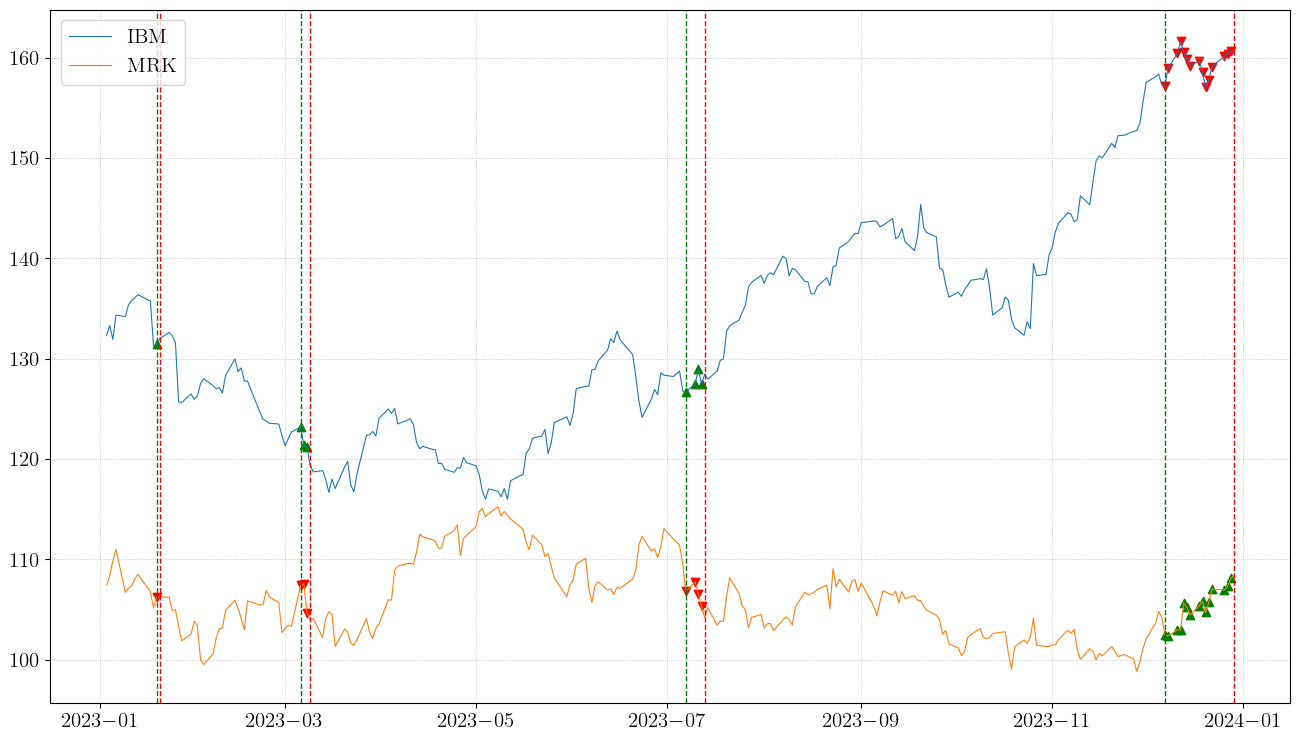

In [44]:
plt.plot(asset_A.loc[output_arma_df.index], label=ticker_A)
plt.plot(asset_B.loc[output_arma_df.index], label=ticker_B)
# Plot trading signals
for date, position in data_arma[data_arma['Position'] != 0].iterrows():
    if position['Position'] == 1:
        plt.scatter(date, asset_A.loc[output_arma_df.index].loc[date], marker='^', color='green')
        plt.scatter(date, asset_B.loc[output_arma_df.index].loc[date], marker='v', color='red')
    elif position['Position'] == -1:
        plt.scatter(date, asset_A.loc[output_arma_df.index].loc[date], marker='v', color='red')
        plt.scatter(date, asset_B.loc[output_arma_df.index].loc[date], marker='^', color='green')

# Find indices where a new position is opened (Position goes from 0 to 1 or -1)
new_position = data_arma[(data_arma['Position'] != 0) & (data_arma['Position'].shift(1) == 0)].index

# Find indices where a position is closed (Position goes from 1 or -1 to 0)
closed_position = data_arma[(data_arma['Position'] == 0) & (data_arma['Position'].shift(1) != 0) & (data_arma['Position'].shift(1).notna())].index

# Plot vertical lines for new position and closed position
for date in new_position:
    plt.axvline(x=date, color='green', linestyle='--', linewidth=1)

for date in closed_position:
    plt.axvline(x=date, color='red', linestyle='--', linewidth=1)

plt.grid(linestyle = ':', linewidth = 0.5)
plt.legend();

In [45]:
index_returns = prices_index.loc[output_arma_df.index].pct_change()

In [46]:
def strategy_return(row, slope):
    if row['Position'] == 1:  # Long position
        if slope <= 1:
            return row['Asset B LogReturns'] - slope * row['Asset A LogReturns']
        else:
            return (1 / slope) * row['Asset B LogReturns'] - row['Asset A LogReturns']
    elif row['Position'] == -1:  # Short position
        if slope <= 1:
            return slope * row['Asset A LogReturns'] - row['Asset B LogReturns']
        else:
            return row['Asset A LogReturns'] - (1 / slope) * row['Asset B LogReturns']
    return 0


In [47]:
reg = linregress(asset_A[asset_A.index < split_date], asset_B[asset_B.index < split_date])
beta = reg.slope
beta

0.5928725258983056

Since $\beta = 0.59 \leq 1$ when entering in a long position we buy 1 m.u. of Asset B and sell $\beta$ m.u. of Asset A, while if we enter in a short position we buy $\beta$ m.u. of Asset A and sell 1 m.u. of Asset B

In [48]:
returns_arma = pd.DataFrame(index = data_arma.index)
returns_arma['Asset A'] = asset_A.loc[output_arma_df.index]
returns_arma['Asset B'] = asset_B.loc[output_arma_df.index] 
returns_arma['Position'] = data_arma['Position']
returns_arma['Asset A LogReturns'] = np.log(asset_A/ asset_A.shift(1))
returns_arma['Asset B LogReturns'] = np.log(asset_B/ asset_B.shift(1))

returns_arma['Strategy LogReturns'] = returns_arma.apply(
            lambda row: strategy_return(row, beta), axis=1)

returns_arma['Cumulative Strategy Return'] = np.exp(returns_arma['Strategy LogReturns'].cumsum()) - 1
returns_arma['Index Returns'] = index_returns.cumsum()
returns_arma

,Asset A,Asset B,Position,Asset A LogReturns,Asset B LogReturns,Strategy LogReturns,Cumulative Strategy Return,Index Returns
Date,,,,,,,,
2023-01-03,132.320663,107.433395,0,0.004673,0.001711,0.000000,0.000000,NaN
2023-01-04,133.302216,108.342049,0,0.007391,0.008422,0.000000,0.000000,0.004026
2023-01-05,131.909378,109.850029,0,-0.010504,0.013823,0.000000,0.000000,-0.006184
2023-01-06,134.330490,111.009995,0,0.018188,0.010504,0.000000,0.000000,0.015089
2023-01-09,134.190292,106.698746,0,-0.001044,-0.039611,0.000000,0.000000,0.011730
...,...,...,...,...,...,...,...,...
2023-12-22,159.095825,107.021141,-1,0.008423,0.012238,-0.007244,-0.031766,0.127107
2023-12-26,160.145752,106.951584,-1,0.006578,-0.000650,0.004550,-0.027350,0.131369
2023-12-27,160.391052,107.299385,-1,0.001531,0.003247,-0.002339,-0.029623,0.134331


### LSTM

In [49]:
output_lstm_df['Predicted Change'] = ((output_lstm_df['Forecasted'].shift(-1) - output_lstm_df['Observed']) / output_lstm_df['Observed']) * 100
output_lstm_df

,Observed,Forecasted,Predicted Change
Date,,,
2023-01-03,0.412772,0.379509,64.976421
2023-01-04,0.722226,0.680977,45.464053
2023-01-05,1.108390,1.050579,32.103515
2023-01-06,1.552676,1.464222,-84.284691
2023-01-09,0.274858,0.244008,50.183600
...,...,...,...
2023-12-20,0.647517,0.608572,43.365405
2023-12-21,0.979670,0.928315,36.996898
2023-12-22,1.419970,1.342118,-3.937450


In [50]:
# Initialize variables
position_lstm = []  # To keep track of trades
long_position_trigger = positive_decile  # Set your long position trigger threshold
short_position_trigger = negative_decile  # Set your short position trigger threshold
current_position = None  # Track the current position ('long', 'short', or None)

# Iterate through the DataFrame
for today, row in output_lstm_df.iterrows():
    # We need the next day's predicted value, so we skip the last iteration
    if today == output_lstm_df.index[-1]:
        break
    
    predicted_change = row['Predicted Change']
    
    # Check conditions to enter position_lstm
    if predicted_change >= long_position_trigger and current_position == None:
        position_lstm.append({'Date': today, 'Position': 'Enter Long', 'Predicted Change': predicted_change})
        current_position = 'long'
    elif predicted_change <= short_position_trigger and current_position == None:
        position_lstm.append({'Date': today, 'Position': 'Enter Short', 'Predicted Change': predicted_change})
        current_position = 'short'
    
    # Check condition to close position
    if current_position == 'long' and predicted_change < 0:
        position_lstm.append({'Date': today, 'Position': 'Exit Long', 'Predicted Change': predicted_change})
        current_position = None
    elif current_position == 'short' and predicted_change > 0:
        position_lstm.append({'Date': today, 'Position': 'Exit Short', 'Predicted Change': predicted_change})
        current_position = None

# Convert the position_lstm list to a DataFrame
position_lstm_df = pd.DataFrame(position_lstm)
position_lstm


[{'Date': Timestamp('2023-01-03 00:00:00'),
  'Position': 'Enter Long',
  'Predicted Change': 64.97642090593104},
 {'Date': Timestamp('2023-01-06 00:00:00'),
  'Position': 'Exit Long',
  'Predicted Change': -84.28469062275393},
 {'Date': Timestamp('2023-01-09 00:00:00'),
  'Position': 'Enter Long',
  'Predicted Change': 50.18360012780475},
 {'Date': Timestamp('2023-01-13 00:00:00'),
  'Position': 'Exit Long',
  'Predicted Change': -63.660012875132345},
 {'Date': Timestamp('2023-01-17 00:00:00'),
  'Position': 'Enter Short',
  'Predicted Change': -190.9414478317503},
 {'Date': Timestamp('2023-01-19 00:00:00'),
  'Position': 'Exit Short',
  'Predicted Change': 27.70430171090742},
 {'Date': Timestamp('2023-01-23 00:00:00'),
  'Position': 'Enter Short',
  'Predicted Change': -649.7629578207583},
 {'Date': Timestamp('2023-01-24 00:00:00'),
  'Position': 'Exit Short',
  'Predicted Change': 9.776785704416223},
 {'Date': Timestamp('2023-01-25 00:00:00'),
  'Position': 'Enter Long',
  'Predicte

In [51]:
data_lstm = output_lstm_df.copy()

# Initialize the position column with 0s
data_lstm['Position'] = 0

# Set your long and short position trigger thresholds
long_position_trigger = positive_decile
short_position_trigger = negative_decile

# Variables to track the current position state
current_position = 0  # 0 for no position, 1 for long, -1 for short

# Iterate through the DataFrame
for today, row in data_lstm.iterrows():
    # We need the next day's predicted value, so we skip the last iteration
    if today == data_lstm.index[-1]:
        break
    
    predicted_change = row['Predicted Change']
    
    # Determine if we should enter a long position
    if predicted_change > long_position_trigger and current_position == 0:
        current_position = 1
    # Determine if we should enter a short position
    elif predicted_change < short_position_trigger and current_position == 0:
        current_position = -1
    # Determine if we should exit the position
    elif (current_position == 1 and predicted_change < 0) or \
         (current_position == -1 and predicted_change > 0):
        current_position = 0
    
    # Update the position for today
    data_lstm.at[today, 'Position'] = current_position

# The new DataFrame df now has the 'Position' column updated as per the strategy
data_lstm

,Observed,Forecasted,Predicted Change,Position
Date,,,,
2023-01-03,0.412772,0.379509,64.976421,1
2023-01-04,0.722226,0.680977,45.464053,1
2023-01-05,1.108390,1.050579,32.103515,1
2023-01-06,1.552676,1.464222,-84.284691,0
2023-01-09,0.274858,0.244008,50.183600,1
...,...,...,...,...
2023-12-20,0.647517,0.608572,43.365405,0
2023-12-21,0.979670,0.928315,36.996898,0
2023-12-22,1.419970,1.342118,-3.937450,0


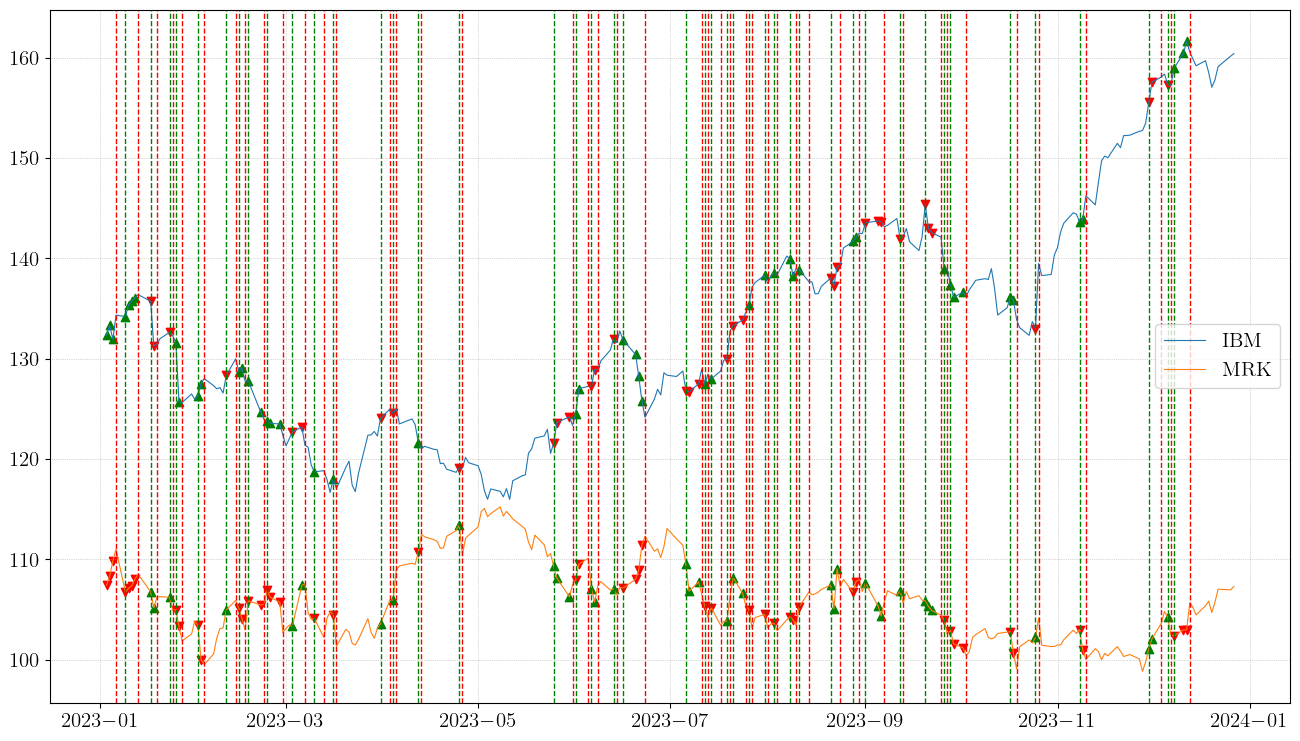

In [52]:
plt.plot(asset_A.loc[output_lstm_df.index], label = ticker_A)
plt.plot(asset_B.loc[output_lstm_df.index], label =ticker_B)
# Plot trading signals
for date, position in data_lstm[data_lstm['Position'] != 0].iterrows():
    if position['Position'] == 1:
        plt.scatter(date, asset_A.loc[output_lstm_df.index].loc[date], marker='^', color='green')
        plt.scatter(date, asset_B.loc[output_lstm_df.index].loc[date], marker='v', color='red')
    elif position['Position'] == -1:
        plt.scatter(date, asset_A.loc[output_lstm_df.index].loc[date], marker='v', color='red')
        plt.scatter(date, asset_B.loc[output_lstm_df.index].loc[date], marker='^', color='green')

# Find indices where a new position is opened (Position goes from 0 to 1 or -1)
new_positions = data_lstm[(data_lstm['Position'] != 0) & (data_lstm['Position'].shift(1) == 0)].index

# Find indices where a position is closed (Position goes from 1 or -1 to 0)
closed_positions = data_lstm[(data_lstm['Position'] == 0) & (data_lstm['Position'].shift(1) != 0) & (data_lstm['Position'].shift(1).notna())].index

# Plot vertical lines for new positions and closed positions
for date in new_positions:
    plt.axvline(x=date, color='green', linestyle='--', linewidth=1)

for date in closed_positions:
    plt.axvline(x=date, color='red', linestyle='--', linewidth=1)

plt.grid(linestyle = ':', linewidth = 0.5)
plt.legend();

In [53]:
returns_lstm = pd.DataFrame(index = data_lstm.index)
returns_lstm['Asset A'] = asset_A.loc[output_arma_df.index]
returns_lstm['Asset B'] = asset_B.loc[output_arma_df.index] 
returns_lstm['Position'] = data_lstm['Position']
returns_lstm['Asset A LogReturns'] = np.log(asset_A/ asset_A.shift(1))
returns_lstm['Asset B LogReturns'] = np.log(asset_B/ asset_B.shift(1))

returns_lstm['Strategy LogReturns'] = returns_lstm.apply(
            lambda row: strategy_return(row, beta), axis=1)

returns_lstm['Cumulative Strategy Return'] = np.exp(returns_lstm['Strategy LogReturns'].cumsum()) - 1
returns_lstm['Index Returns'] = index_returns.cumsum()
returns_lstm

,Asset A,Asset B,Position,Asset A LogReturns,Asset B LogReturns,Strategy LogReturns,Cumulative Strategy Return,Index Returns
Date,,,,,,,,
2023-01-03,132.320663,107.433395,1,0.004673,0.001711,-0.001060,-0.001059,NaN
2023-01-04,133.302216,108.342049,1,0.007391,0.008422,0.004041,0.002985,0.004026
2023-01-05,131.909378,109.850029,1,-0.010504,0.013823,0.020050,0.023298,-0.006184
2023-01-06,134.330490,111.009995,0,0.018188,0.010504,0.000000,0.023298,0.015089
2023-01-09,134.190292,106.698746,1,-0.001044,-0.039611,-0.038992,-0.015834,0.011730
...,...,...,...,...,...,...,...,...
2023-12-20,157.045074,104.695900,0,-0.009390,-0.010668,0.000000,0.176311,0.118905
2023-12-21,157.761353,105.719406,0,0.004551,0.009729,0.000000,0.176311,0.127598
2023-12-22,159.095825,107.021141,0,0.008423,0.012238,0.000000,0.176311,0.127107


## Results

Total Index Return: 13.74%
Total ARMA Pairs Trading Return: -3.57%
Total LSTM Pairs Trading Return: 17.63%


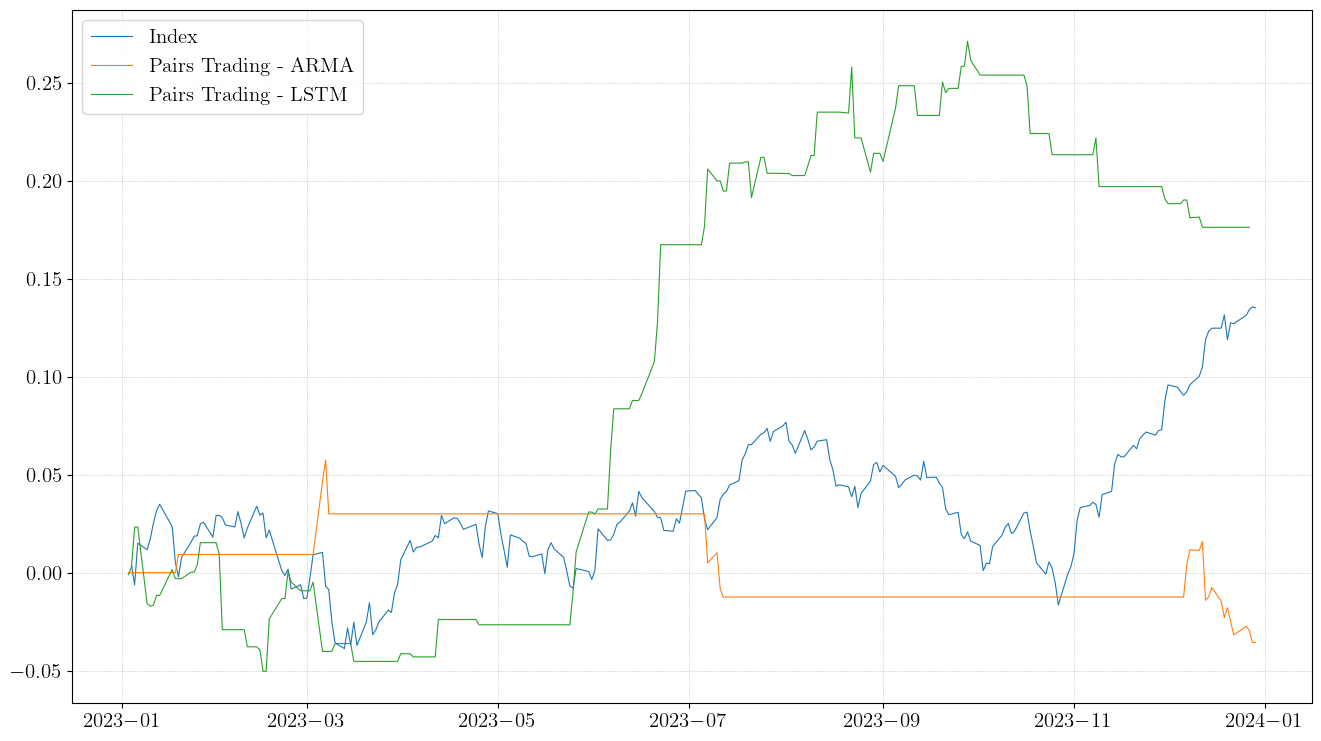

Sharpe Ratio for Index: 0.0754
Sharpe Ratio for ARMA Pairs Trading Strategy: -0.0311
Sharpe Ratio for LSTM Pairs Trading Strategy: 0.0840


In [54]:
# Compute and print the total returns
total_index_return = (prices_index.loc[test_data.index][-1] - prices_index.loc[test_data.index][0])/prices_index.loc[test_data.index][0]
total_arma_return = returns_arma['Cumulative Strategy Return'][-1]
total_lstm_return = returns_lstm['Cumulative Strategy Return'][-1]

print("Total Index Return: {:.2%}".format(total_index_return))
print("Total ARMA Pairs Trading Return: {:.2%}".format(total_arma_return))
print("Total LSTM Pairs Trading Return: {:.2%}".format(total_lstm_return))

# Plotting the cumulative returns
plt.plot(index_returns.loc[test_data.index].cumsum(), label = 'Index')
plt.plot(returns_arma['Cumulative Strategy Return'], label = 'Pairs Trading - ARMA')
plt.plot(returns_lstm['Cumulative Strategy Return'], label = 'Pairs Trading - LSTM')
plt.grid(linestyle = ':', linewidth = 0.5)
plt.legend()
plt.show()

# Compute and print Sharpe Ratio
mean_index_returns = (index_returns).mean()
std_dev_index = (index_returns).std()
sharpe_ratio_index = mean_index_returns / std_dev_index

mean_arma_returns = (np.exp(returns_arma['Strategy LogReturns']) - 1).mean()
std_dev_arma = (np.exp(returns_arma['Strategy LogReturns']) - 1).std()
sharpe_ratio_arma = mean_arma_returns / std_dev_arma

mean_lstm_returns = (np.exp(returns_lstm['Strategy LogReturns']) - 1).mean()
std_dev_lstm = (np.exp(returns_lstm['Strategy LogReturns']) - 1).std()
sharpe_ratio_lstm = mean_lstm_returns / std_dev_lstm

print(f"Sharpe Ratio for Index: {sharpe_ratio_index:.4f}")
print(f"Sharpe Ratio for ARMA Pairs Trading Strategy: {sharpe_ratio_arma:.4f}")
print(f"Sharpe Ratio for LSTM Pairs Trading Strategy: {sharpe_ratio_lstm:.4f}")

## Index Implementation

We take blocks of 5 years [t − 4, t] where we use the first 4 years [t − 4, t − 1] as training set and the last year t as test set or live set , and we roll the block yearly, effectively producing a continuous time interval of non-overlapping live sets.
For each partition we run the cointegration test on the training set, storing all the information (slope, thresholds) of each cointegrated pair found needed for the strategy.

In [110]:
class PairsTradingModel:
    def __init__(self, tickers, start, end, model_type):
        self.tickers = tickers
        self.start = start
        self.end = end
        self.model_type = model_type  # 'ARMA' or 'LSTM'
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.data = yf.download(tickers, self.start, self.end)['Adj Close']
   

    def spread_calc(self, asset_A, asset_B):
        reg = linregress(asset_A, asset_B)
        self.beta = reg.slope
        spread = asset_B - self.beta * asset_A

        # Normalize spread
        normalized_spread = (spread - spread.mean()) / spread.std()
        spread_df = pd.DataFrame(normalized_spread, columns=['Spread'])
        return spread_df


    def set_triggers(self, spread):
        percentage_change = (spread.pct_change() * 100).dropna()
        self.long_trigger = np.percentile(percentage_change['Spread'], 90)
        self.short_trigger = np.percentile(percentage_change['Spread'], 10)


    def forecast_arma(self, train_data, test_data):
        history = [x for x in train_data['Spread']] 
        output = []

        for t in range(len(test_data)):
            obs = test_data.iloc[t]['Spread'] 
            model = ARIMA(history, order=(1, 0, 1))
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            date = test_data.index[t]

            output.append({
                'Date': date,
                'Observed': obs,
                'Forecasted': yhat,
                'Slope': self.beta,
                'Long Threshold': self.long_trigger,
                'Short Threshold': self.short_trigger
            })

            history.append(obs)  # Append the actual observed value to history

        return output


    def create_dataset(self, dataset, look_back=5):
        dataX, dataY = [], []
        for i in range(len(dataset) - look_back):
            a = dataset[i:(i + look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)

   
    def forecast_lstm(self, train_data, test_data):
        # Set seeds for reproducibility
        np.random.seed(42)
        tf.random.set_seed(42)
        random.seed(42)

        output=[]

        train_data_scaled = self.scaler.fit_transform(train_data)
        test_data_scaled = self.scaler.fit_transform(test_data)

        X_train, y_train = self.create_dataset(train_data_scaled, 5)
        X_test, y_test = self.create_dataset(test_data_scaled, 5)

        # Reshape input to be [samples, time steps, features]
        X_train = np.reshape(X_train, (X_train.shape[0], 5, 1))
        X_test = np.reshape(X_test, (X_test.shape[0], 5, 1))

        model = Sequential()
        model.add(LSTM(4, input_shape=(1, 1)))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0)

        # Make predictions
        testPredict = model.predict(X_test, verbose=0)
        predicted_values_lstm = self.scaler.inverse_transform(testPredict)
        observed_values_lstm = self.scaler.inverse_transform(y_test.reshape(-1, 1))
    
        for t in range(len(observed_values_lstm)):
            output.append({
                'Date': test_data.index[t],
                'Observed': observed_values_lstm[t, 0],
                'Forecasted': predicted_values_lstm[t, 0],
                'Slope': self.beta,
                'Long Threshold': self.long_trigger,
                'Short Threshold': self.short_trigger,
            })

        return output


    def determine_positions(self, forecast):
        forecast['Position'] = 0
        current_position = 0

        for today, row in forecast.iterrows():
            if today == forecast.index[-1]:
                break

            predicted_change = row['Predicted Change']
            long_position_trigger = row['Long Threshold']
            short_position_trigger = row['Short Threshold']

            if predicted_change > long_position_trigger and current_position == 0:
                current_position = 1
            elif predicted_change < short_position_trigger and current_position == 0:
                current_position = -1
            elif (current_position == 1 and predicted_change < 0) or \
                 (current_position == -1 and predicted_change > 0):
                current_position = 0

            forecast.at[today, 'Position'] = current_position


    def calculate_returns(self, forecast_df, ticker_A, ticker_B):
        forecast_df['Position Change'] = forecast_df['Position'].diff().ne(0)
        forecast_df['Asset A Returns'] = np.log(self.data[ticker_A].pct_change() + 1)
        forecast_df['Asset B Returns'] = np.log(self.data[ticker_B].pct_change() + 1)
        forecast_df['Strategy Returns'] = forecast_df.apply(
            lambda row: self.strategy_return(row), axis=1)

        return forecast_df
        

    def strategy_return(self, row):
        if row['Position'] == 1:  # Long position
            if row['Slope'] <= 1:
                trade_return = row['Asset B Returns'] - row['Slope'] * row['Asset A Returns']
                trade_return -= trade_return*0.001 #0.1% of transaction costs
                return trade_return
            else:
                trade_return = (1 / row['Slope']) * row['Asset B Returns'] - row['Asset A Returns']
                trade_return -= trade_return*0.001 #0.1% of transaction costs
                return trade_return
        elif row['Position'] == -1:  # Short position
            if row['Slope'] <= 1:
                trade_return = row['Slope'] * row['Asset A Returns'] - row['Asset B Returns']
                trade_return -= trade_return*0.001 #0.1% of transaction costs
                trade_return -= trade_return*0.01 #1% of short selling costs
                return trade_return
            else:
                trade_return =  row['Asset A Returns'] - (1 / row['Slope']) * row['Asset B Returns']
                trade_return -= trade_return*0.001 #0.1% of transaction costs
                trade_return -= trade_return*0.01 #1% of short selling costs               
                return trade_return
        return 0


    def process_partitions(self):
        all_returns = []

        end_year = self.end.year
        
        # Calculate total number of partitions to process
        total_partitions = self.end.year - self.start.year - 4   # assuming each partition spans 4 years

        # Initialize the start and end of the window
        window_start = self.start.year
        window_end = self.start.year + 4  # 3 years after the start, inclusive
        self.tot_forecast = []

        with tqdm(total=total_partitions, desc=f"{self.model_type} Processing Partitions", unit="partition") as pbar:
            while window_start + 4 < end_year:
                # Define the training and testing periods
                training_start = pd.to_datetime(f'{window_start}-01-01')
                training_end = pd.to_datetime(f'{window_start + 3}-12-31') 
                test_start = pd.to_datetime(f'{window_start + 4}-01-01')  
                test_end = pd.to_datetime(f'{window_start + 4}-12-31') 

                # Slice the DataFrame for training and testing data
                self.train_data = self.data.loc[training_start:training_end]
                self.test_data = self.data.loc[test_start:test_end]

                # Cointegration Test
                pairs = list(itertools.combinations(self.tickers, 2))
                cointegrated_pairs = []
                for row in pairs:
                    try:
                        ticker_A, ticker_B = row
                        asset_A = self.train_data[ticker_A]
                        asset_B = self.train_data[ticker_B]
                        if coint(asset_A, asset_B)[1] < 0.05:
                            cointegrated_pairs.append(row)
                    except:
                        pass

                num_pairs = len(cointegrated_pairs)
                if num_pairs == 0:
                    pbar.update(1)  # Update progress bar if no pairs found
                    window_start += 1
                    window_end += 1
                    continue  # Skip to the next partition

                # Forecasting and collecting results through each cointegrated pair
                for row in cointegrated_pairs:
                    self.ticker_A, self.ticker_B = row
                    spread_test = self.spread_calc(self.test_data[self.ticker_A], self.test_data[self.ticker_B])
                    spread_train = self.spread_calc(self.train_data[self.ticker_A], self.train_data[self.ticker_B])
                    self.set_triggers(spread_train)

                    if self.model_type == 'ARMA':  
                        forecast = self.forecast_arma(spread_train, spread_test)
                    elif self.model_type == 'LSTM':
                        forecast = self.forecast_lstm(spread_train, spread_test)

                    forecast_df = pd.DataFrame(forecast)
                    forecast_df.set_index('Date', inplace=True)
                    forecast_df['Predicted Change'] = ((forecast_df['Forecasted'].shift(-1) - forecast_df['Observed']) / forecast_df['Observed']) * 100
                    self.determine_positions(forecast_df)
                    returns_df = self.calculate_returns(forecast_df, ticker_A, ticker_B)
                    all_returns.append(returns_df)
                    
                    pbar.update(1 / num_pairs)  # Update the progress bar proportionally

                # Increment the window by one year for the next loop
                window_start += 1
                window_end += 1

        # Aggregate all returns into a single DataFrame 
        total_returns_df = pd.concat(all_returns)
        self.daily_aggregated_returns = total_returns_df.groupby(total_returns_df.index)['Strategy Returns'].sum()



In [111]:
resp = requests.get('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[1].text
    tickers.append(ticker)
tickers = [s.replace('\n', '') for s in tickers]
tickers.remove('DOW')

In [112]:
start = datetime.datetime(2009, 1, 1)
end = datetime.datetime(2024, 1, 1)

In [113]:
# Create instances of the PairsTradingModel for both ARMA and LSTM
arma_model = PairsTradingModel(tickers, start, end, 'ARMA')
lstm_model = PairsTradingModel(tickers, start, end, 'LSTM')

# Process the partitions and calculate returns
lstm_model.process_partitions()
arma_model.process_partitions()


arma_daily_returns = arma_model.daily_aggregated_returns
lstm_daily_returns = lstm_model.daily_aggregated_returns

[*********************100%%**********************]  29 of 29 completed
[*********************100%%**********************]  29 of 29 completed
LSTM Processing Partitions: 100%|██████████| 11.00000000000004/11 [4:18:33<00:00, 1410.28s/partition]   
ARMA Processing Partitions: 100%|██████████| 11.00000000000004/11 [2:07:00<00:00, 692.74s/partition]   


In [163]:
index = yf.download('^DJI', start=datetime.datetime(2013, 1, 1), end=datetime.datetime(2024, 1, 1))   
prices_index = index['Adj Close']
index_return = prices_index.pct_change()

[*********************100%%**********************]  1 of 1 completed


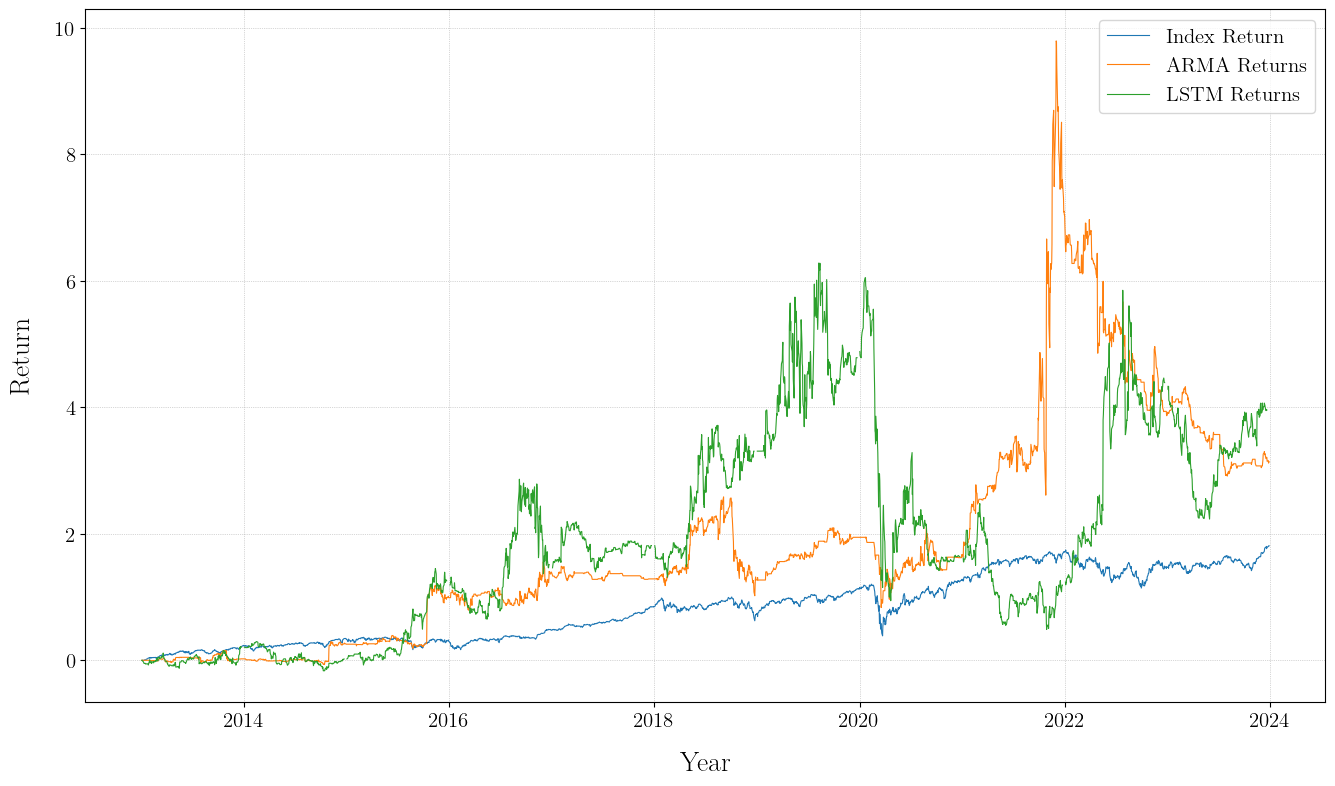

In [199]:
strategy_returns = pd.DataFrame({
    'ARMA LogReturns': arma_daily_returns,
    'LSTM LogReturns': lstm_daily_returns,
    'Index LogReturns': np.log(1 + index_return)
})

# Calculate cumulative log-returns
strategy_returns['ARMA Cumulative LogReturns'] = strategy_returns['ARMA LogReturns'].cumsum()
strategy_returns['LSTM Cumulative LogReturns'] = strategy_returns['LSTM LogReturns'].cumsum()
strategy_returns['Index Cumulative LogReturns'] = strategy_returns['Index LogReturns'].cumsum()


# Convert to cumulative log-returns
strategy_returns['ARMA Cumulative Returns'] = np.exp(strategy_returns['ARMA Cumulative LogReturns']) - 1
strategy_returns['LSTM Cumulative Returns'] = np.exp(strategy_returns['LSTM Cumulative LogReturns']) - 1
strategy_returns['Index Cumulative Returns'] = np.exp(strategy_returns['Index Cumulative LogReturns']) - 1

plt.plot(strategy_returns.index, strategy_returns['Index Cumulative Returns'], label='Index Return')
plt.plot(strategy_returns.index, strategy_returns['ARMA Cumulative Returns'], label='ARMA Returns')
plt.plot(strategy_returns.index, strategy_returns['LSTM Cumulative Returns'], label='LSTM Returns')
plt.xlabel('Year', fontsize = 20, labelpad = 15)
plt.ylabel('Return', fontsize = 20, labelpad = 15)
plt.grid(linestyle = ':', linewidth = 0.5)
plt.legend();


In [165]:
# Add a year column to the DataFrame
strategy_returns['Year'] = strategy_returns.index.year

# Function to calculate annual metrics
def calculate_annual_metrics(returns_df, return_column, risk_free_rate=0.01):
    metrics = {}
    grouped = returns_df.groupby('Year')
    
    for year, data in grouped:
        total_return = (np.exp(data[return_column].sum()) - 1)
        volatility = data[return_column].std() * np.sqrt(252)
        sharpe_ratio = (total_return - risk_free_rate) / volatility

        metrics[year] = {
            'Total Return': total_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio
        }
    
    return pd.DataFrame(metrics).T


# Calculate metrics for ARMA, LSTM, and Index
arma_metrics = calculate_annual_metrics(strategy_returns, 'ARMA LogReturns')
lstm_metrics = calculate_annual_metrics(strategy_returns, 'LSTM LogReturns')
index_metrics = calculate_annual_metrics(strategy_returns, 'Index LogReturns')

# Combine metrics into a single DataFrame
annual_metrics = pd.concat([index_metrics, arma_metrics, lstm_metrics], axis=1, keys=['Index', 'ARMA', 'LSTM']).round(4)

# Display the metrics
annual_metrics


Index                                 ARMA             \
     Total Return Volatility Sharpe Ratio Total Return Volatility   
2013       0.2359     0.0993       2.2755       0.0223     0.2068   
2014       0.0752     0.1089       0.5985       0.2270     0.2373   
2015      -0.0223     0.1546      -0.2092       0.5866     0.3941   
2016       0.1342     0.1262       0.9836       0.2031     0.3684   
2017       0.2508     0.0662       3.6359      -0.0449     0.1005   
2018      -0.0563     0.1796      -0.3692      -0.0071     0.4479   
2019       0.2234     0.1246       1.7129       0.2968     0.1628   
2020       0.0725     0.3704       0.1686      -0.0924     0.4735   
2021       0.1873     0.1244       1.4251       2.0089     0.7813   
2022      -0.0878     0.1984      -0.4930      -0.3946     0.4007   
2023       0.1370     0.1140       1.1142      -0.1497     0.1391   

                          LSTM                          
     Sharpe Ratio Total Return Volatility Sharpe Ratio  
2013       0.0595       0.2083     0.3791       0.5232  
2014       0.9141      -0.1553     0.3387      -0.4880  
2015       1.4630       1.2116     0.4684       2.5653  
2016       0.5243       0.1133     0.7359       0.1404  
2017      -0.5459       0.1197     0.2985       0.3674  
2018      -0.0381       0.5308     0.5803       0.8975  
2019       1.7618       0.3430     0.7067       0.4713  
2020      -0.2163      -0.5440     0.8790      -0.6303  
2021       2.5585      -0.1701     0.5746      -0.3134  
2022      -1.0097       1.4629     0.7502       1.9367  
2023      -1.1478      -0.0805     0.3247      -0.2788

In [166]:
annual_metrics.mean()

Index  Total Return    0.104536
       Volatility      0.151509
       Sharpe Ratio    0.985718
ARMA   Total Return    0.241455
       Volatility      0.337491
       Sharpe Ratio    0.393036
LSTM   Total Return    0.276336
       Volatility      0.548736
       Sharpe Ratio    0.471936
dtype: float64